Let's start by installing hugging face's transformers library.

In [1]:
!pip install transformers

We will be using the IMDB Review dataset. Let's download it and extract the compressed file.

In [2]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

--2021-07-05 02:59:40--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.1’

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M  77.1MB/s    in 1.0s    

2021-07-05 02:59:42 (77.1 MB/s) - ‘aclImdb_v1.tar.gz.1’ saved [84125825/84125825]

^C


In [47]:
#importing necessary libraries
import pandas as pd
import numpy as np
import random
#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from pathlib import Path
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# Data Loading

Let's start processing the data. The dataset is devided into test and train folders, each folder has sub folders with pos & neg folder with all the text files which contains the review text.

In [5]:
def read_imdb_split(split_dir):
    split_dir = Path(split_dir)
    data = pd.DataFrame(columns = ["texts", "labels"])
    for label_dir in ["pos", "neg"]:
        for text_file in tqdm((split_dir/label_dir).iterdir(), label_dir):
            row = {"texts" : text_file.read_text(), "labels" : 1 if label_dir is "pos" else 0}
            data = data.append(row, ignore_index=True)
    return data

In [6]:
train_data = read_imdb_split('aclImdb/train')

pos: 12500it [00:48, 256.84it/s]
neg: 12500it [01:05, 191.35it/s]


In [7]:
test_data = read_imdb_split('aclImdb/test')

pos: 12500it [00:46, 270.19it/s]
neg: 12500it [01:02, 198.83it/s]


In [2]:
path = 'data/'

In [8]:
train_data.to_csv(path + "train.csv", index=False)
test_data.to_csv(path + "test.csv", index=False)

Loading data from csv file.

In [3]:
train_df = pd.read_csv(path + 'train.csv')
test_df = pd.read_csv(path + 'test.csv')

train_df.head()

,texts,labels
0,There's perhaps a special reason why The Fox a...,1
1,"With the death of her infirmed husband, May, a...",1
2,Tim Krabbe is the praised author of 'Het Goude...,1
3,"Cary Grant, Douglas Fairbanks Jr. and Victor M...",1
4,Sure Star Wars (a movie I have seen at least f...,1


In [6]:
print("Train dataset shape", train_df.shape)
print("Test dataset shape", test_df.shape)

Train dataset shape (25000, 2)
Test dataset shape (25000, 2)


Both train and test datasets have same number of observations i.e., 25000

# Data Visualization

Let's understand the train data set by the help of visulazation techniques.

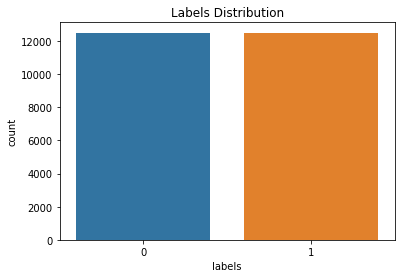

In [23]:
sns.countplot(x = train_df.labels)
plt.title("Labels Distribution")
plt.show()

The Data Set is balaced with same number of observations for both the classes.

In [24]:
#number of words in each review text
train_df['no_of_words'] = train_df['texts'].apply(lambda x: len(x.split()))

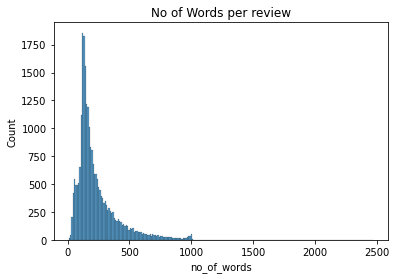

In [29]:
sns.histplot(train_df['no_of_words'])
plt.title("No of Words per review")
plt.show()

In [31]:
train_df['no_of_words'].describe()

count    25000.000000
mean       233.787200
std        173.733032
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: no_of_words, dtype: float64

Number of words is left skewed distribution. with min # of words 10 and max are 2470 words.

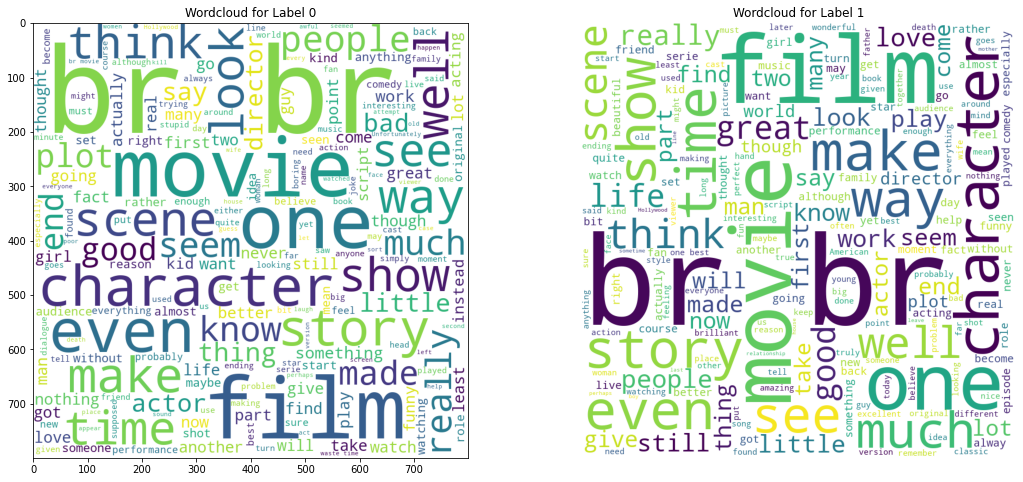

In [46]:
plt.figure(figsize = (18, 8), facecolor = None)

for i in range(0,2):
  reviewes = " ".join(train_df[train_df.labels == i]['texts'])
  wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='white',
                  min_font_size = 5).generate(reviewes)

  plt.subplot(1, 2, i+1)
  plt.imshow(wordcloud)
  plt.title("Wordcloud for Label "+str(i))

plt.axis("off")
plt.show()

Most of the words are repeated in both labels. Words like *great, character, much, lot* more frequent in Positive Review. 

# Data Preperation

Let's Split the train data set into validationa and train. Validation data set will be used for evaluation after each epoch.

In [4]:
train_df, val_df = train_test_split(train_df, test_size=.2)

In [5]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(20000, 2)
(5000, 2)
(25000, 2)


We will use a modified version of bert (DistilBERT), this is a smaller version of BERT made by huggingface for faster training and consumes less memory.

In [6]:
PRETRAIN_MODEL = "distilbert-base-uncased"

All the text need to be tokenized before feeding to Network. We will use the tokenizer from the pretrained model i.e., distil bert

In [7]:
tokenizer = AutoTokenizer.from_pretrained(PRETRAIN_MODEL)

Let's create a Dataset object, which will be used iterate through all the values in training.

In [8]:
class IMDBDataset(Dataset):
  def __init__(self, data):
    self.data = data
  def __getitem__(self, idx):
    # tokenizing and converting them to index
    encodings = tokenizer(self.data.iloc[idx][0], truncation=True, padding="max_length")
    encodings['labels'] = self.data.iloc[idx][1]
    return encodings
  def __len__(self):
    return self.data.shape[0]

In [9]:
#creating datset classes for train, validationa and test data
train_dataset = IMDBDataset(train_df)
val_dataset = IMDBDataset(val_df)
test_dataset = IMDBDataset(test_df)

# Model Building

Hugging face provides the Auto Classes for picking up the relevent model for our use case. In our case we will be usign Sequence Classification model.

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(PRETRAIN_MODEL, num_labels=2)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.8.2",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9a

In [15]:
# setting training arguments for trainer
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    do_eval = True,
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [16]:
# We will Hugginface Trainer for training the model
trainer = Trainer(
    model=model,                         # Hugging face Transformers model to be trained
    args=training_args,                  # training arguments
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [17]:
trainer.train()

***** Running training *****
  Num examples = 20000
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1250


Step,Training Loss
100,0.677900
200,0.378100
300,0.337600
400,0.299800
500,0.323300
600,0.291700
700,0.275900
800,0.261800
900,0.251900
1000,0.254100


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1250, training_loss=0.3121280723571777, metrics={'train_runtime': 1110.6065, 'train_samples_per_second': 18.008, 'train_steps_per_second': 1.126, 'total_flos': 4113715814400000.0, 'train_loss': 0.3121280723571777, 'epoch': 1.0})

The model is able to learn, as we can see the loss has comedown from 0.6 to 0.2.

# Model Inference

In [23]:
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [52]:
test = test_df.iloc[random.randint(0, test_df.shape[0])]
print("Text :", test[0])
input = tokenizer(test[0], return_tensors="pt").to("cuda")
label = torch.tensor([test[1]]).unsqueeze(0).to('cuda')
outputs = model(**input, labels = label)
pred = torch.argmax(outputs.logits, dim=-1)

print("True :", test[1], "\nPredicted :", pred.cpu().numpy()[0])

Text : The movie was good. Really the only reason I watched it was Alan Rickman. Which he didn't pull off the southern accent,but he did pretty well with it.Know Emma Thompson did really good she definitely pulled off the southern accent. I like all the character in my opinion not one of them did bad,another thing I have notice. I have read all these comment and not one person has comment on Alan 5 0'clock shadow. Which made him look even better and he pretty much had one through the whole movie. I would give the movie a 9 out of 10. Another one of my opinions is the movie would been better if there wasn't any sex. Still it was alright. Love the scene were he says "Aw sh*t" when he is setting in his car and see them in his mirror.
True : 1 
Predicted : 1
